## XGB Base Model for Speech Emotion Recognitioin

Import Required Libraries

In [1]:
import pandas as pd 
import librosa
import numpy as np
from tqdm import tqdm
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder,  StandardScaler
import joblib

Import Dataset 
* Make sure that the dataset is downsampled and augmented using the scripts provided

In [2]:
df = pd.read_csv("../../.././augment/train.csv") #Enter path after downsampling

Encode emotions to numeric values

In [3]:
label_encoder = LabelEncoder()
df["Emotion_Code"] = label_encoder.fit_transform(df["Emotions"])

Feature Extraction (Work in Progress)
* Currently consiering mfcc, chroma and contrast

In [19]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfccs_mean = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)
    chroma_mean = np.mean(librosa.feature.chroma_stft(y=y, sr=sr), axis=1)
    contrast_mean = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr), axis=1)

    features = {}
    for i in range(13):
        features[f'mfccs_mean_{i}'] = mfccs_mean[i]
    for i in range(12):
        features[f'chroma_mean_{i}'] = chroma_mean[i]
    for i in range(7):
        features[f'contrast_mean_{i}'] = contrast_mean[i]
    return features

tqdm.pandas(desc="Extracting Features")

features_list = df['Path'].progress_apply(extract_features).tolist()
features_df = pd.DataFrame(features_list)

df = pd.concat([df, features_df], axis=1)

Extracting Features:  25%|██▌       | 13836/54459 [05:06<17:21, 39.00it/s]f:\anaconda3\envs\fusemachines\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Extracting Features: 100%|██████████| 54459/54459 [19:24<00:00, 46.75it/s]


In [27]:
df.to_csv("features.csv", index = False)

Create trainng and testing sets

In [4]:
df = pd.read_csv("features.csv")

In [5]:
scaler = StandardScaler()
X = df.drop(columns=['Path', 'Emotions', 'Emotion_Code'], axis=1)
X = scaler.fit_transform(X)
y = df['Emotion_Code']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Create XGB model and train

In [9]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 500, 1000],
}

In [ ]:
model = xgb.XGBClassifier(objective='multi:softprob', num_class=len(y.unique()))

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, verbose=10)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

In [9]:
model.fit(X_train, y_train, verbose=True)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None, num_class=7,
              num_parallel_tree=None, ...)

In [14]:
joblib.dump(best_model, "model.pkl")

['model.pkl']

In [7]:
joblib.dump(scaler, "scaler.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")

['label_encoder.pkl']

Model evaluation

In [8]:
best_model = joblib.load("model.pkl")
scaler = joblib.load("scaler.pkl")
label_encoder = joblib.load("label_encoder.pkl")

In [9]:
y_pred = best_model.predict(X_test)

In [10]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(classification_report(y_test, y_pred))

Accuracy: 79.41%
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1759
           1       0.76      0.73      0.75      1783
           2       0.79      0.74      0.76      1750
           3       0.77      0.75      0.76      1686
           4       0.78      0.80      0.79      1649
           5       0.78      0.83      0.80      1756
           6       0.94      0.92      0.93       509

    accuracy                           0.79     10892
   macro avg       0.81      0.81      0.81     10892
weighted avg       0.79      0.79      0.79     10892



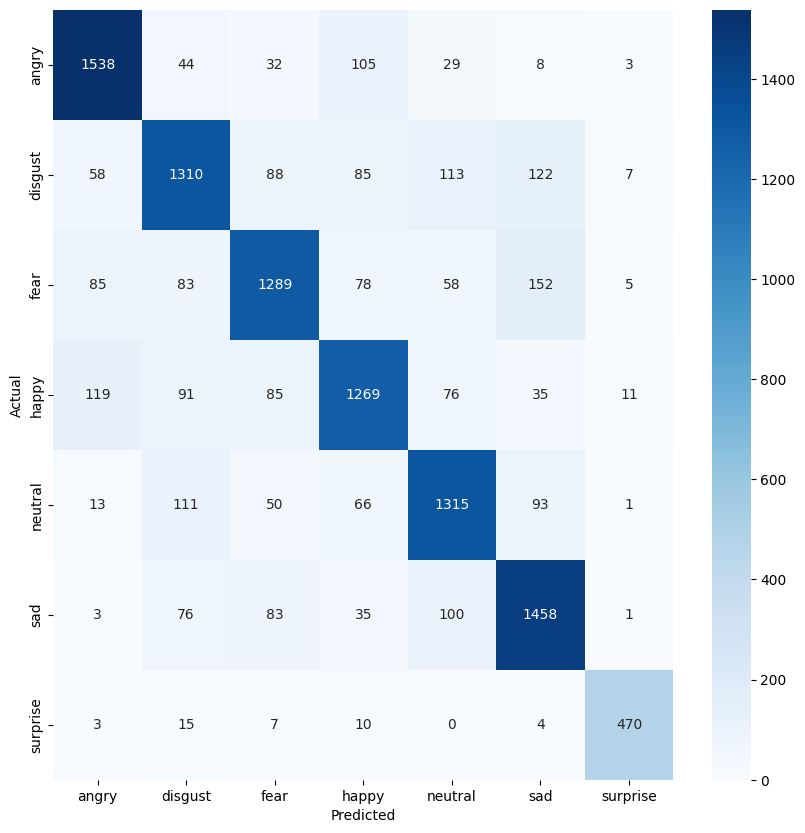

In [12]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap = "Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()